## 趨勢跟蹤 Trend-following Effect in Stocks

* 投資範圍設定：投資台股最具流動性的股票，且股價不小於新台幣10元。
* 入場條件：若今日收盤價高於該股票一年來最高收盤價，則發出入場信號。
* 出場條件：使用 10 日平均真實波幅（ATR）作為跟蹤停損信號。當股票的價格低於當前價格減去 ATR 時，執行出場。
* 持倉管理：投資者持有所有符合入場條件且未被停損的股票。組合等權重，每日再平衡。
* 交易成本：台灣手續費模型

這個策略的目標是捕捉股票市場中的趨勢，通過在股價上揚力道強勁時入場，並使用ATR作為跟蹤停損出場。

In [4]:
import os
import tejapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# set tej_key and base
tej_key = 'your key'
api_base = 'https://api.tej.com.tw'

os.environ['TEJAPI_KEY'] = tej_key
os.environ['TEJAPI_BASE'] = api_base
start = '2019-04-01'
end = '2024-04-01'

In [5]:
from zipline.sources.TEJ_Api_Data import get_universe
pool = get_universe(start, end, mkt = ['TWSE', 'OTC'], stktp_e=['Common Stock-Foreign', 'Common Stock'])
len(pool)

Currently used TEJ API key call quota 12/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 6455567/9223372036854775807 (0.0%)


1890

In [6]:
tickers = ' '.join(pool)
start_dt, end_dt = pd.Timestamp(start, tz='utc'), pd.Timestamp(end, tz='utc')
os.environ['ticker'] = ''.join(tickers) +' IR0001'
os.environ['mdate'] = start+' '+end

In [7]:
!zipline ingest -b tquant

[2024-06-05 06:34:49.885083] INFO: zipline.data.bundles.core: Ingesting tquant.
Merging daily equity files:  [####################################]      
Currently used TEJ API key call quota 18/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 12872518/9223372036854775807 (0.0%)
[2024-06-05 06:39:48.690012] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [32]:
from zipline.pipeline.factors import TrueRange, CustomFactor
from zipline.utils.math_utils import nanmax
from numpy import dstack
from zipline.pipeline.data import TWEquityPricing, EquityPricing
from zipline.pipeline.factors import CustomFactor
from zipline.pipeline.data.TQFundamentals import TQData

class AverageTrueRange(CustomFactor):

    inputs = (
        EquityPricing.high,
        EquityPricing.low,
        EquityPricing.close,
    )

    window_length = 10

    outputs = ["TR", "ATR"]

    def compute(self, today, assets, out, highs, lows, closes):

        high_to_low = highs[1:] - lows[1:]
        high_to_prev_close = abs(highs[1:] - closes[:-1])
        low_to_prev_close = abs(lows[1:] - closes[:-1])
        tr_current = nanmax(
            dstack(
                (
                    high_to_low,
                    high_to_prev_close,
                    low_to_prev_close,
                )
            ),
            2,
        )

        sma_atr_values = np.mean(tr_current, axis=0)

        out.TR = tr_current[-1]
        out.ATR = sma_atr_values

class N_Year_Highest(CustomFactor):

    window_length = 252

    def compute(self, today, assets, out, highs):

        out[:] = np.nanmax(highs[: int(self.window_length)-1], axis=0)

In [9]:
from zipline.pipeline.filters import StaticAssets
from zipline.data import bundles
bundle = bundles.load('tquant')
benchmark_asset = bundle.asset_finder.lookup_symbol('IR0001',as_of_date = None)

In [10]:
from zipline.pipeline import Pipeline
from zipline.TQresearch.tej_pipeline import run_pipeline
def make_pipeline():
    volume = TWEquityPricing.volume.latest
    curr_price = TWEquityPricing.close.latest
    highest_price = N_Year_Highest(inputs = [TWEquityPricing.close])

    sample = curr_price.__ge__(highest_price) # find stocks that >= highest price
    vol_rank = volume.rank(mask = sample & curr_price.__ge__(10)) # rank the price that >= 10 and stocks that >= highest price

    ATR = AverageTrueRange(inputs = [TWEquityPricing.high,
                                 TWEquityPricing.low,
                                 TWEquityPricing.close])
    return Pipeline(
        columns = {
            'vol_rank':vol_rank,
            'curr_price': curr_price,
            'highest_price': highest_price,
            'atr': ATR.ATR,
            'sample': sample,
            'volume':volume
            },
            screen = ~StaticAssets([benchmark_asset])
        )
my_pipeline = run_pipeline(make_pipeline(), start_dt, end_dt)
my_pipeline

vol_rank  curr_price  \
2019-04-02 00:00:00+00:00 Equity(0 [1101])          NaN       41.35   
                          Equity(1 [1102])          NaN       40.50   
                          Equity(2 [1103])          NaN       15.00   
                          Equity(3 [1104])          NaN       19.75   
                          Equity(4 [1108])          NaN        7.44   
...                                                 ...         ...   
2024-04-01 00:00:00+00:00 Equity(1885 [9951])       NaN       72.30   
                          Equity(1886 [9955])       NaN       24.75   
                          Equity(1887 [9958])       NaN      218.50   
                          Equity(1888 [9960])       NaN       27.05   
                          Equity(1889 [9962])       NaN       17.95   

                                               highest_price        atr  \
2019-04-02 00:00:00+00:00 Equity(0 [1101])               NaN        NaN   
                          Equity(1 [1102])               NaN        NaN   
                          Equity(2 [1103])               NaN        NaN   
                          Equity(3 [1104])               NaN        NaN   
                          Equity(4 [1108])               NaN        NaN   
...                                                      ...        ...   
2024-04-01 00:00:00+00:00 Equity(1885 [9951])          81.00   0.922222   
                          Equity(1886 [9955])          29.55   0.694444   
                          Equity(1887 [9958])         260.00  13.388889   
                          Equity(1888 [9960])          29.20   0.155556   
                          Equity(1889 [9962])          22.25   0.238889   

                                               sample      volume  
2019-04-02 00:00:00+00:00 Equity(0 [1101])      False  28261000.0  
                          Equity(1 [1102])      False  14565000.0  
                          Equity(2 [1103])      False   2288000.0  
                          Equity(3 [1104])      False    233000.0  
                          Equity(4 [1108])      False     38000.0  
...                                               ...         ...  
2024-04-01 00:00:00+00:00 Equity(1885 [9951])   False     56000.0  
                          Equity(1886 [9955])   False   3364000.0  
                          Equity(1887 [9958])   False   3212000.0  
                          Equity(1888 [9960])   False     30000.0  
                          Equity(1889 [9962])   False    322000.0  

[2130435 rows x 6 columns]

In [43]:
from zipline.finance import slippage, commission
from zipline.api import *

def initialize(context):
    set_slippage(slippage.VolumeShareSlippage(volume_limit=1, price_impact=0.01))
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
    attach_pipeline(make_pipeline(), 'mystrats')
    set_benchmark(symbol('IR0001'))
    context.stop_loss = {}

In [62]:
def handle_data(context, data):

    context.df = pipeline_output('mystrats')

    space = 10 - len(context.portfolio.positions)

    if space != 0:

        context.latest_target = pipeline_output('mystrats').query("sample == 1")
        context.latest_target['vol_rank'] = pd.to_numeric(context.latest_target['vol_rank'], errors='coerce')
        context.latest_target = context.latest_target.nlargest(space, 'vol_rank')

    open_orders = get_open_orders()

    for symbol, atr in zip(context.latest_target.index, context.latest_target['atr']):

      if symbol not in context.portfolio.positions and symbol not in open_orders and len(context.portfolio.positions) < 10 and atr is not None:

          order_target_percent(symbol, 1 / 10 * 0.95)

          context.stop_loss[f'{symbol}'] = data.current(symbol, 'close') - atr * 1.25

    for symbol in context.portfolio.positions:

      if data.can_trade(symbol):

        if data.current(symbol, 'close') > context.stop_loss[f'{symbol}']:

          new_stop_loss = data.current(symbol, 'close') - context.df.loc[symbol, 'atr'] * 1.25
          context.stop_loss[f'{symbol}'] = new_stop_loss

        if data.current(symbol, 'close') <= context.stop_loss[f'{symbol}'] and symbol not in open_orders:

          order_target_percent(symbol, 0)

In [63]:
def analyze(context, results):
    import matplotlib.pyplot as plt
    plt.style.use('ggplot')

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

    results['benchmark_cum'] = results.benchmark_return.add(1).cumprod()
    results['portfolio_returns'] = results.returns.add(1).cumprod()

    results[['portfolio_returns', 'benchmark_cum']].plot(ax=ax1, label='Portfolio Value($)')
    results[['ending_cash']].plot(ax=ax2, label='Portfolio Cash($)')

    plt.legend(loc='best')

    plt.show()

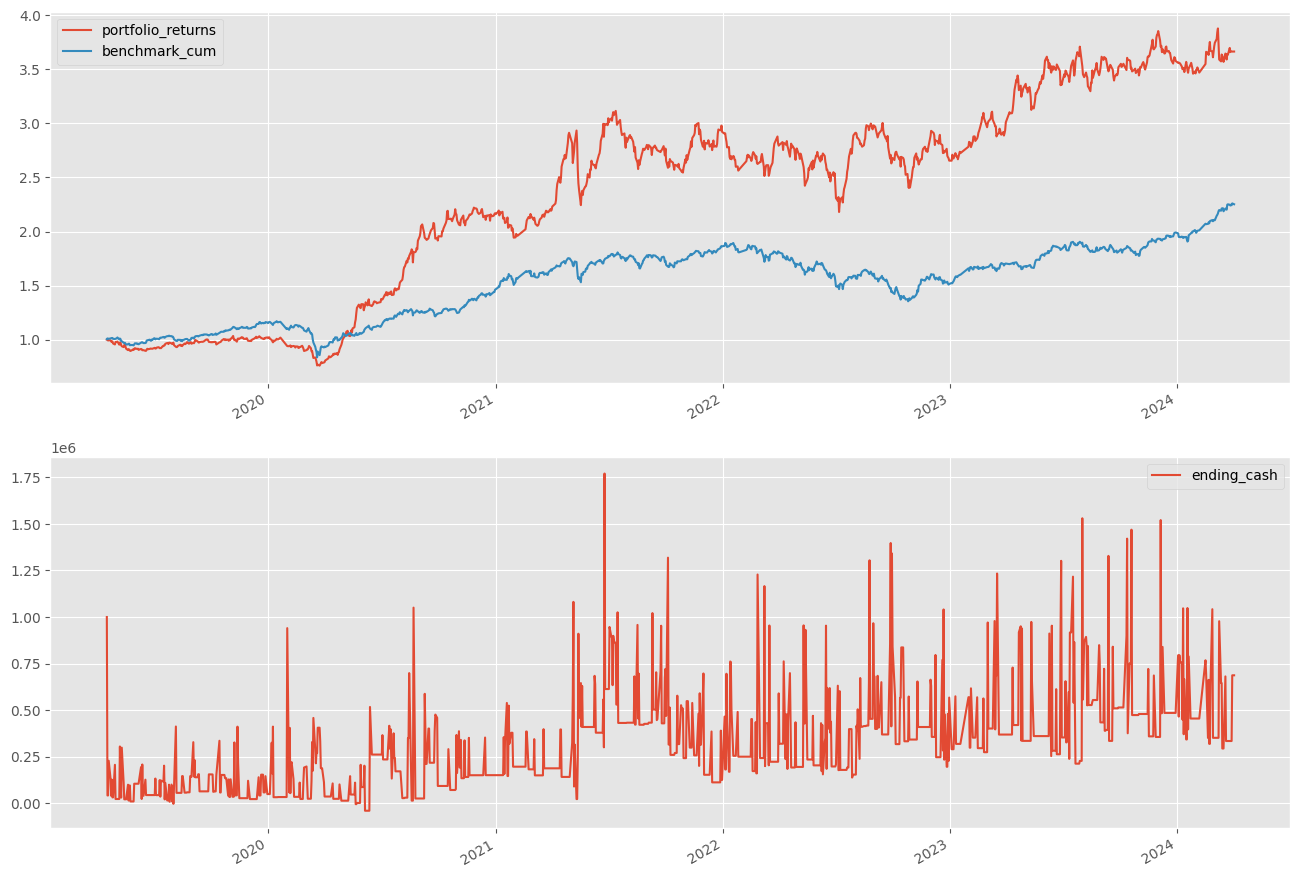

In [64]:
from zipline import run_algorithm
start = '2019-04-16'
end = '2024-04-01'
start_dt, end_dt = pd.Timestamp(start, tz='utc'), pd.Timestamp(end, tz='utc')

results = run_algorithm(
    start = start_dt,
    end = end_dt,
    initialize = initialize,
    bundle = 'tquant',
    analyze = analyze,
    capital_base = 1e6,
    handle_data = handle_data
)

In [65]:
import pyfolio as pf
from zipline.utils.run_algo import  (get_transaction_detail,
                                     get_record_vars)

returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

Start date,2019-04-16
End date,2024-04-01
Total months,57
,Backtest
Annual return,31.065%
Cumulative returns,266.536%
Annual volatility,26.144%
Sharpe ratio,1.17
Calmar ratio,1.03
Stability,0.82
Max drawdown,-30.016%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.02,2021-07-12,2022-07-06,2023-04-11,425
1,26.55,2019-11-05,2020-03-23,2020-05-04,118
2,23.51,2021-05-10,2021-05-17,2021-06-22,31
3,12.51,2020-11-26,2021-01-29,2021-04-01,82
4,11.10,2023-07-28,2023-08-14,2023-11-20,78


Top 10 long positions of all time,max
sid,
1325,35.01%
2014,28.64%
2417,21.05%
6133,18.58%
2387,16.86%
4763,16.28%
2305,15.41%
9919,15.27%
3715,15.25%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
1325,35.01%
2014,28.64%
2417,21.05%
6133,18.58%
2387,16.86%
4763,16.28%
2305,15.41%
9919,15.27%
3715,15.25%


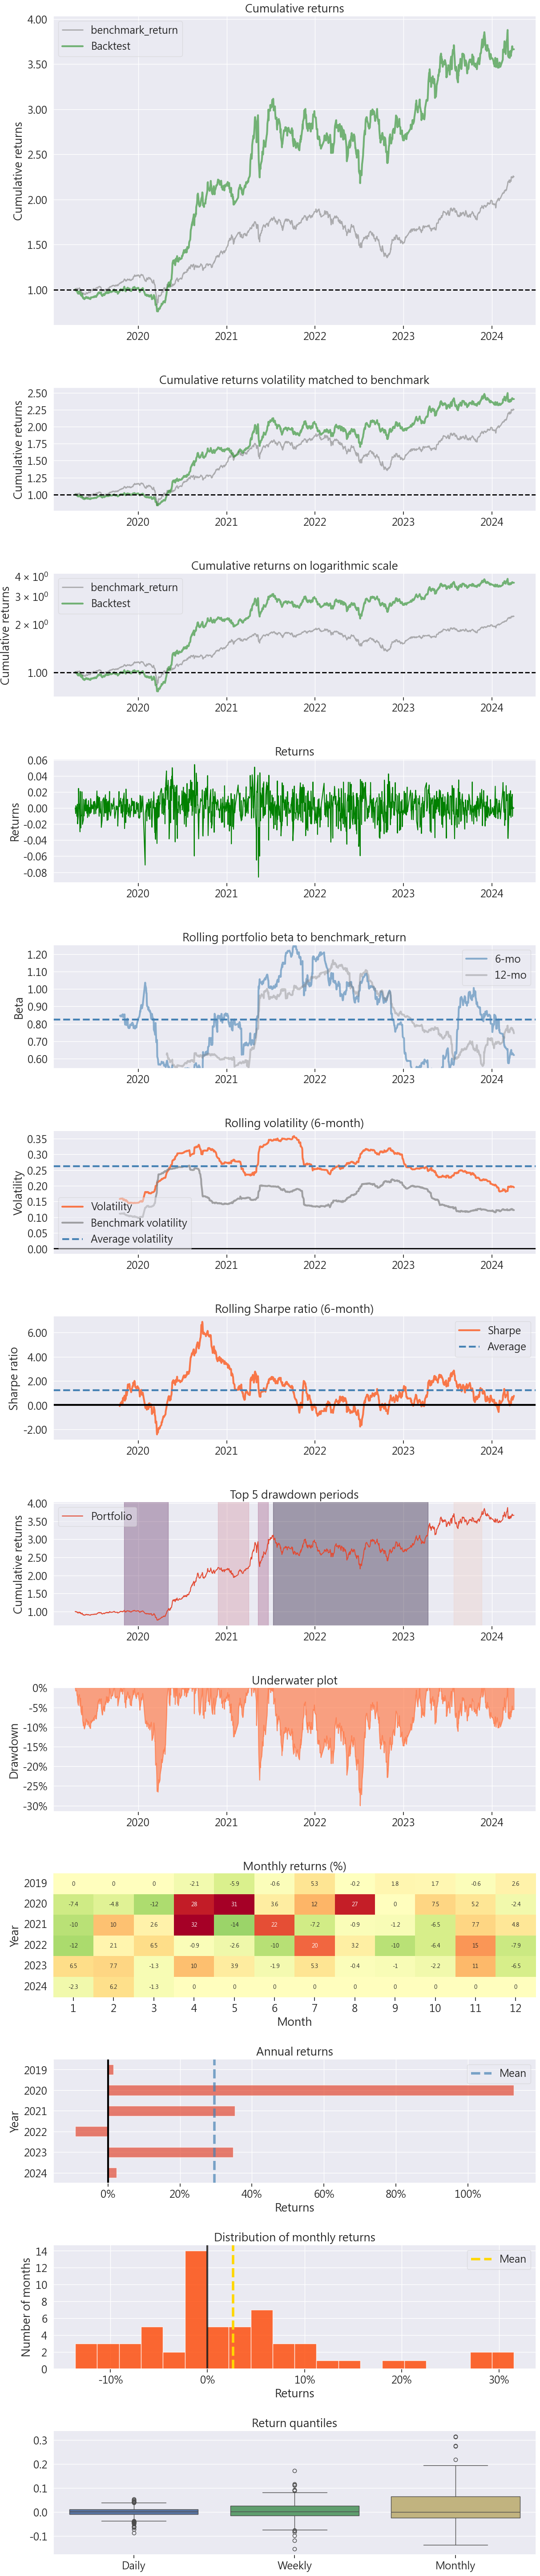

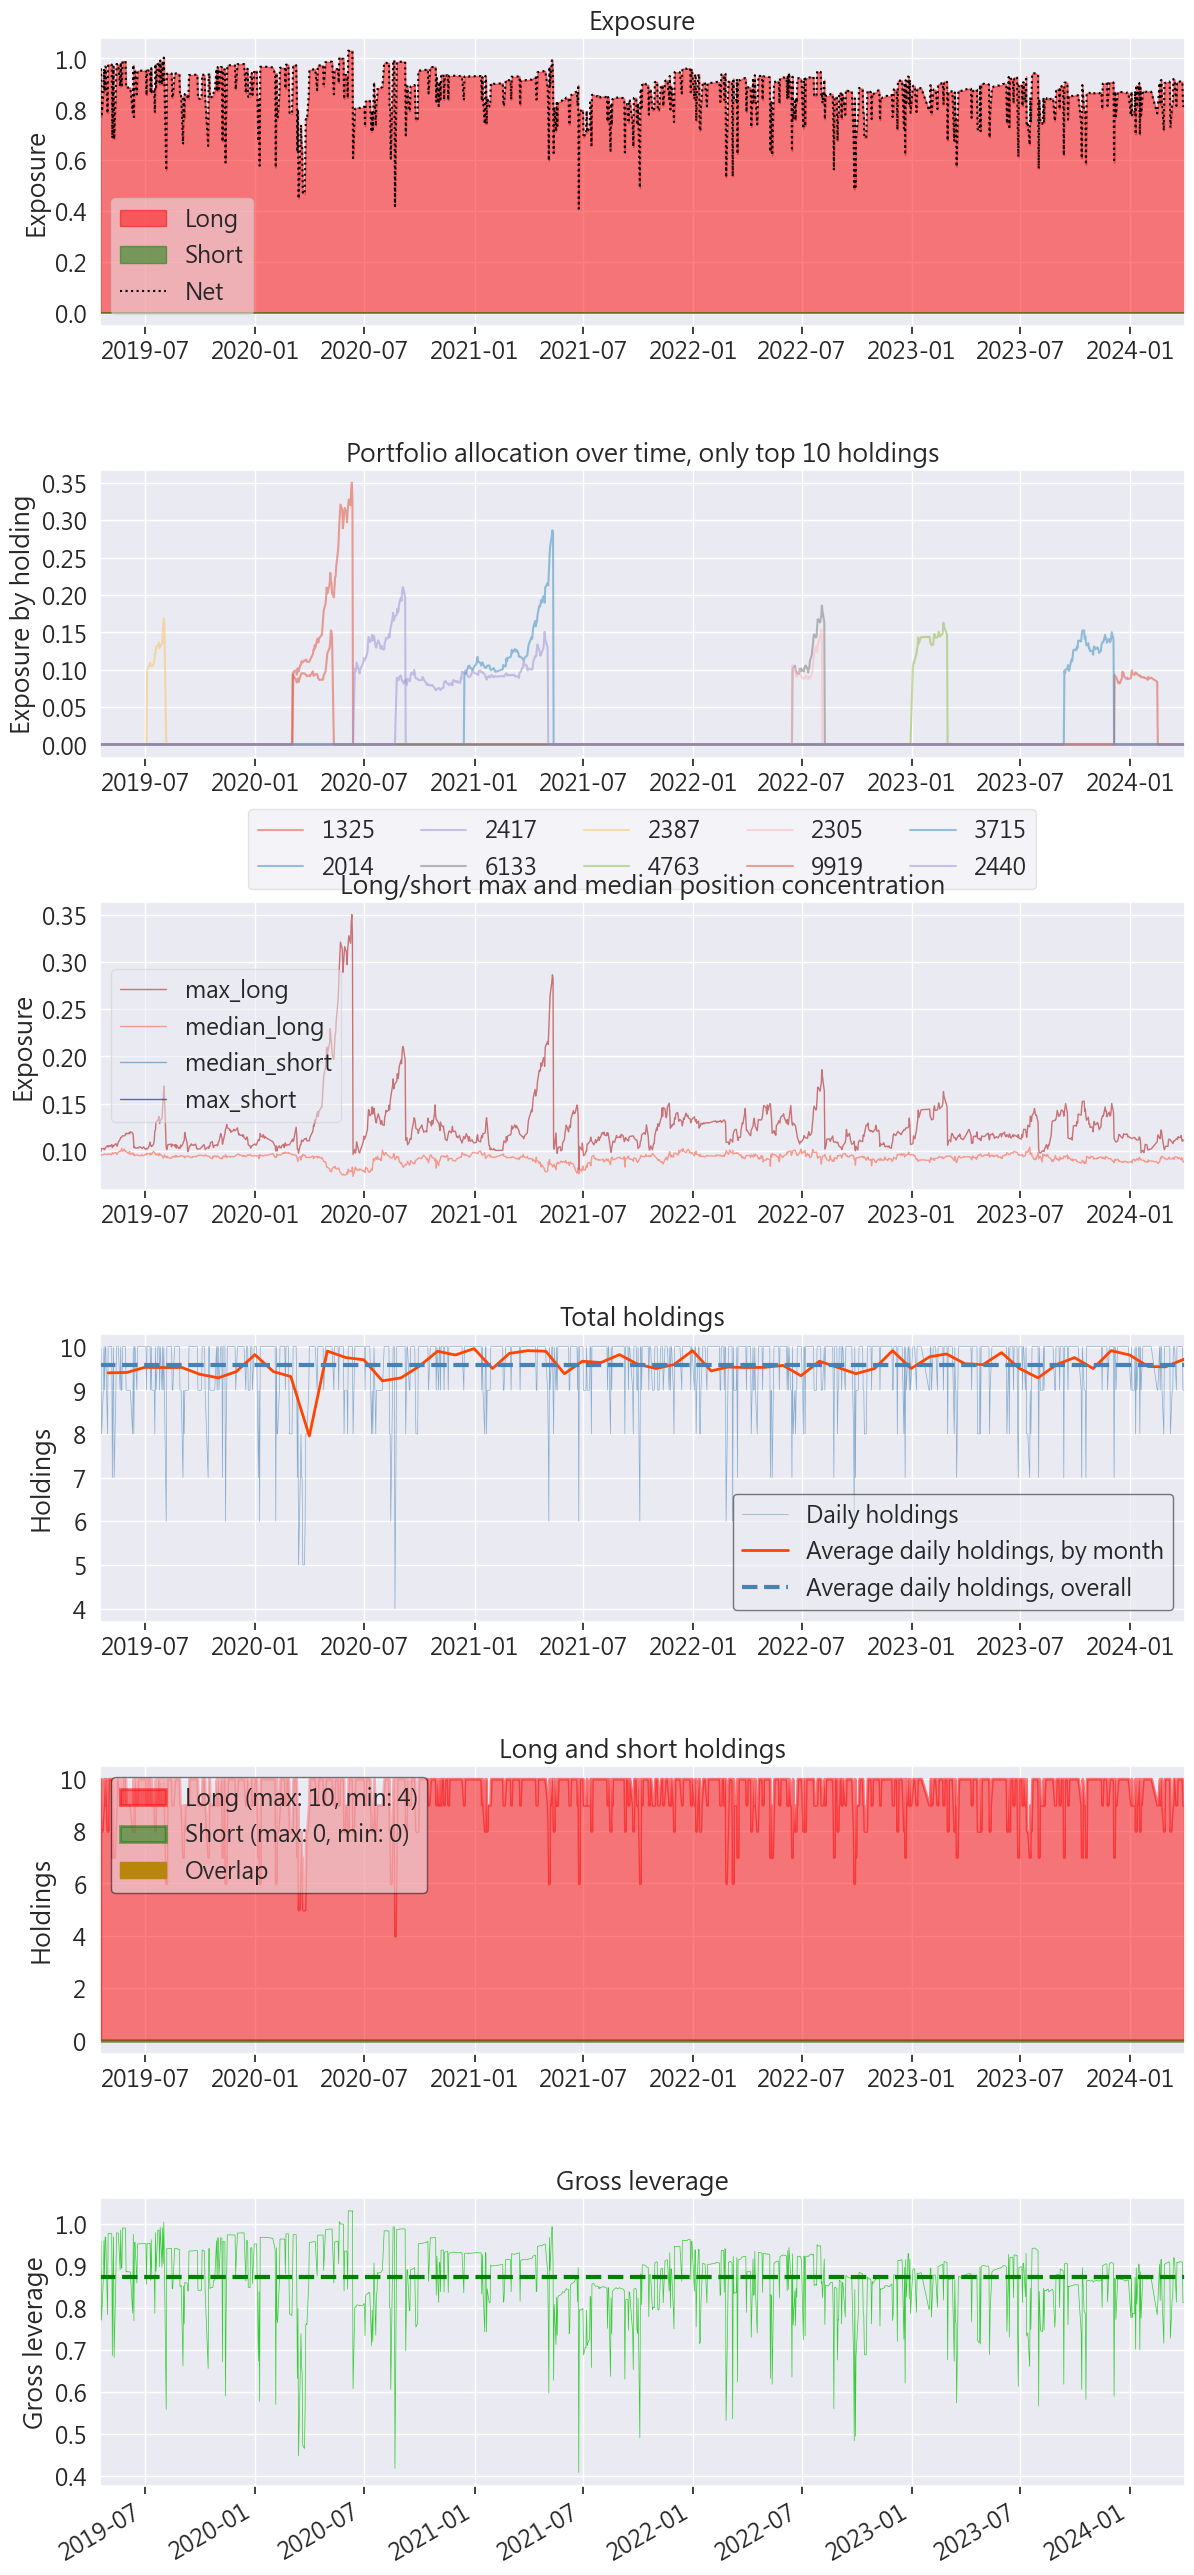

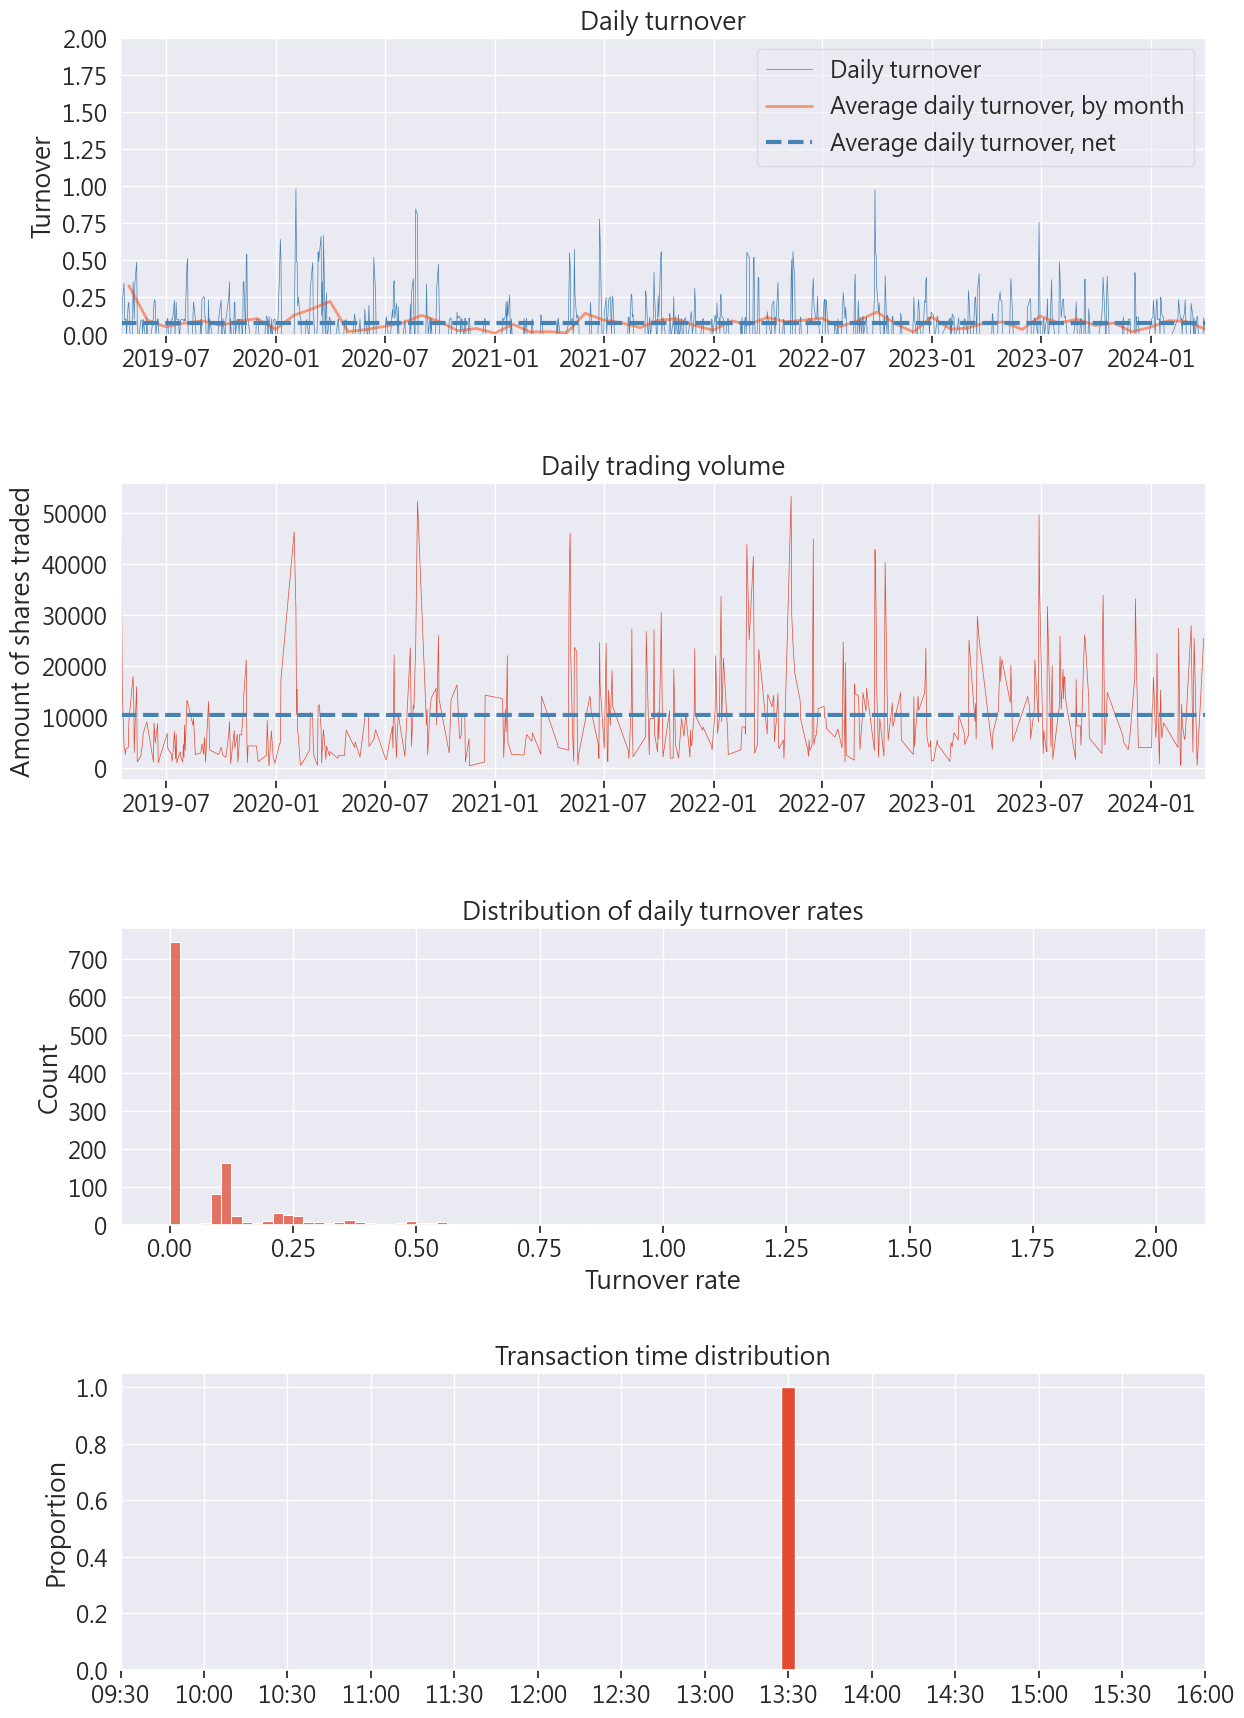

In [68]:
benchmark_rets = results['benchmark_return']
pf.tears.create_full_tear_sheet(returns=returns,
                                positions=positions,
                                transactions=transactions,
                                benchmark_rets=benchmark_rets
                                )